<iframe src="https://www.kaggle.com/embed/abdmental01/cat-vs-dog-transfer-learning-0-99?cellIds=3&kernelSessionId=163139148" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Cat Vs Dog | Transfer Learning | 0.99"></iframe>

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("content/")

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [ ]:
dir="/content/content/MyDrive/brain_tumor_dataset"

# **import libraries**

In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception

from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping


import os
import random

**This code searches for brain images in a designated folder, categorizing them based on the presence or absence of tumors. It examines each subfolder, labeling the images as "yes" for tumor presence or "no" for no tumor. The code then compiles this information into a list, matching each image to its corresponding label.**

In [ ]:
directory = dir

filepaths = []
labels = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepaths.append(img_path)
        labels.append(fold)

file_path_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)


In [ ]:
df_train

,filepath,label
0,/content/content/MyDrive/brain_tumor_dataset/y...,yes
1,/content/content/MyDrive/brain_tumor_dataset/y...,yes
2,/content/content/MyDrive/brain_tumor_dataset/y...,yes
3,/content/content/MyDrive/brain_tumor_dataset/y...,yes
4,/content/content/MyDrive/brain_tumor_dataset/y...,yes
...,...,...
248,/content/content/MyDrive/brain_tumor_dataset/n...,no
249,/content/content/MyDrive/brain_tumor_dataset/n...,no
250,/content/content/MyDrive/brain_tumor_dataset/n...,no
251,/content/content/MyDrive/brain_tumor_dataset/n...,no


# **Data Spliting**


**This code divides the dataset df_train into three parts: train_df (80% for training), valid_df (10% for validation), and test_df (10% for testing). It ensures the data is randomly shuffled and reproducible by using a fixed random seed (42). This process sets up the data for training a machine learning model, while maintaining distinct sets for validation and final evaluation.**

In [ ]:
from sklearn.model_selection import train_test_split

train_df , dummy_df = train_test_split(df_train ,train_size = 0.8 , shuffle = True ,random_state = 42 )
valid_df , test_df = train_test_split(dummy_df ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [ ]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {valid_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (202, 2)
The shape of The Validation data is: (25, 2)
The shape of The Test data is: (26, 2)


# Data Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**This code prepares image data for model training by utilizing ImageDataGenerator to create generators for the training, validation, and test datasets. It applies augmentation techniques such as shearing, zooming, and flipping to the training data (train_datagen), while the validation and test data (validation_test_datagen) are only rescaled. Each dataset (train_ds, validation_ds, test_ds) is loaded from a DataFrame (train_df, valid_df, test_df) that includes file paths and labels. The images are resized to 256x256 pixels, grouped into batches of 12, and configured for binary classification.**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32


In [ ]:


print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Training Data
Found 202 validated image filenames belonging to 2 classes.
Validation Data
Found 25 validated image filenames belonging to 2 classes.
Test Data
Found 26 validated image filenames belonging to 2 classes.


In [ ]:
print("Testing Training Data Generator")
x_train, y_train = next(iter(train_ds))
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("Testing Validation Data Generator")
x_valid, y_valid = next(iter(validation_ds))
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")


Testing Training Data Generator
x_train shape: (32, 256, 256, 3)
y_train shape: (32,)
Testing Validation Data Generator
x_valid shape: (25, 256, 256, 3)
y_valid shape: (25,)


**This code calculates and visualizes the distribution of categories in the 'label' column of the df_train DataFrame. It generates two subplots: the first is a pie chart illustrating the percentage distribution of each category, and the second is a bar chart showing the count of each category.**

# Data Visulization

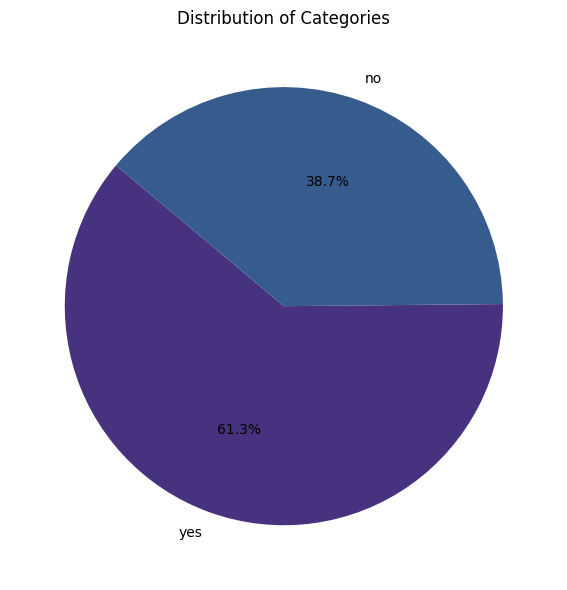

In [ ]:
count = df_train['label'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')

ax.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
ax.set_title('Distribution of Categories')

plt.tight_layout()

plt.show()


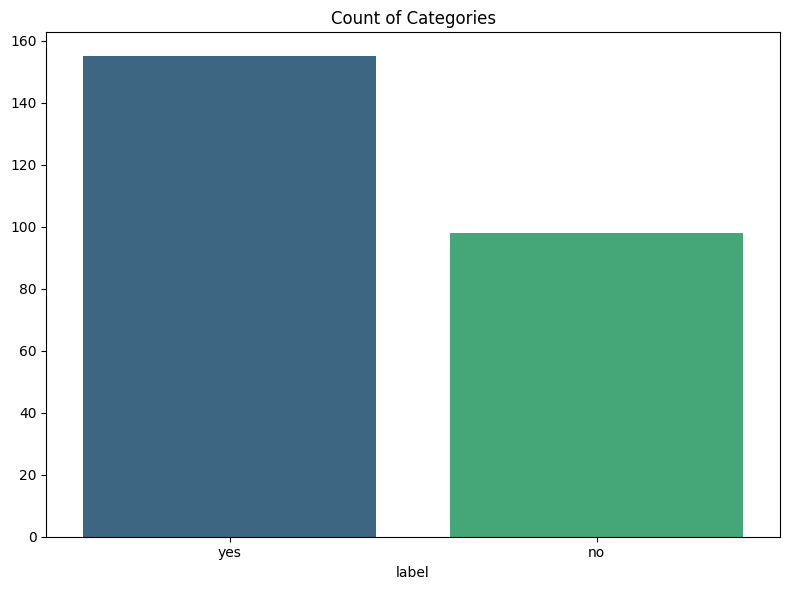

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
sns.barplot(x=count.index, y=count.values, ax=ax, palette="viridis")
ax.set_title('Count of Categories')

plt.tight_layout()

plt.show()

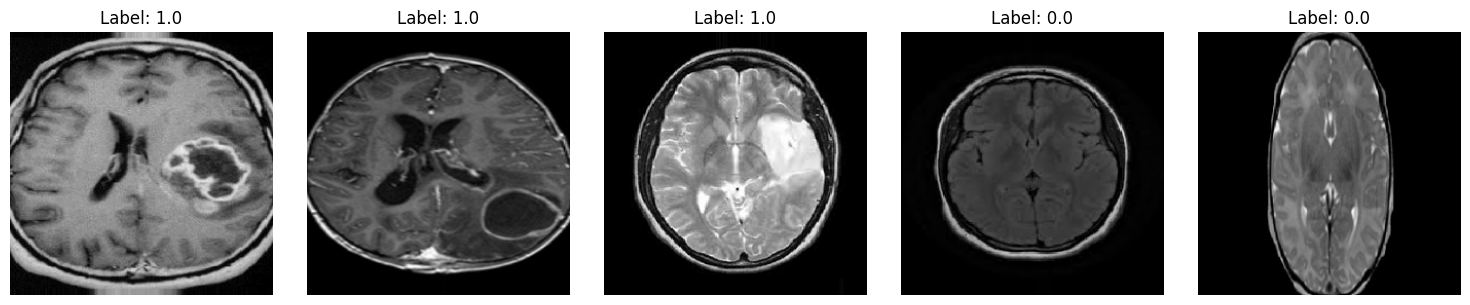

In [ ]:
def display_random_images(generator, num_images):
    batch = next(generator)

    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    plt.tight_layout()
    plt.show()


display_random_images(train_ds, 5)


In [ ]:
# Define the class labels for brain tumor classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')


Class labels: {'no': 0, 'yes': 1}


# **MODEL**

In [ ]:
from tensorflow.keras.applications import Xception

# **transfer-learning**

**ResNet50 pre-trained on ImageNet, excluding the top classification layer, with an input shape of 256x256 pixels and 3 channels (RGB).**

In [ ]:
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

# **Architecture**

In [ ]:
# Build Model
model = Sequential()

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training

In [ ]:
history = model.fit(train_ds,epochs=50,batch_size=32,validation_data=validation_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.5420 - loss: 5.4304 - val_accuracy: 0.4800 - val_loss: 5.5859
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 515ms/step - accuracy: 0.8639 - loss: 4.6199 - val_accuracy: 0.4800 - val_loss: 5.5033
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - accuracy: 0.9456 - loss: 4.1694 - val_accuracy: 0.4800 - val_loss: 4.9778
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.9354 - loss: 3.8269 - val_accuracy: 0.6000 - val_loss: 4.1929
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step - accuracy: 0.9589 - loss: 3.4437 - val_accuracy: 0.6800 - val_loss: 3.6995
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.9254 - loss: 3.2693 - val_accuracy: 0.8800 - val_loss: 3.3333
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - accuracy: 0.9626 - loss: 2.8538 - val_accuracy: 0.8400 - val_loss: 3.0444
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - accuracy: 0.9638 - loss: 2.6321 - val_accuracy: 0.8800 - val_loss:

# Save the Model in Tensorflow

In [ ]:
model.save('model.h5')